# Goal

This will be used to "test" the system that is now parked in the linear regime!

In [9]:
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import astropy.units as u
from astropy.visualization import quantity_support
quantity_support()
u.set_enabled_equivalencies(u.dimensionless_angles())

import torch
import pytorch_lightning as pl

from tdwg.lib.pl_utils import get_logger
from tdwg.lib.misc_utils import *

In [10]:
AVAIL_GPUS = min(1, torch.cuda.device_count())
device = 'cuda' if AVAIL_GPUS else 'cpu'
device = 'cpu'

# Name of the runs

# Load devices

In [11]:
# crazy_reload("tdwg.lib.DMD", globals())

In [12]:
import pickle
import numpy as np
import torch
from torch.nn import functional as F
import pytorch_lightning as pl
from tdwg.lib.line_camera import LineCamera
from tdwg.lib.exp_sim_converter import Exp_Sim_Converter
from tdwg.lib.PCIe_beamshaper import PCIe_beamshaper, pos2ind
from tdwg.lib.DMD import DMD
from tdwg.lib.multiuser_client import Client
from tdwg.lib.tdwgnet import TDwgExperiment, FineTunedSimulation, TDwgModel
import tdwg.lib.ftutils_torch as ftutils_torch
from tdwg.lib.io_utils import crazy_reload

In [13]:
beamshaper = PCIe_beamshaper(mode="local")
linecam = LineCamera(mode="local")
dmd = DMD(mode="local")
client = Client(online_flag=False)

Blink SDK was successfully constructed
Found 1 SLM controller(s)
Loading library: C:/Program Files/ALP-4.2/ALP-4.2 high-speed API/x64/alpV42.dll
DMD found, resolution = 1024 x 768.


In [568]:
with open('calibration_dict.pkl', 'rb') as file:
    calibration_dict = pickle.load(file)

In [570]:
calibration_dict["dn_rescale_factor"] = 1.6*0.8

In [571]:
linecam.load_calibration(calibration_dict)
beamshaper.load_calibration(calibration_dict)
dmd.load_calibration(calibration_dict)

converter = Exp_Sim_Converter(calibration_dict, Ncom=3)
wg = converter.wg

In [572]:
dmd.safety_margin = 495

In [573]:
tdwg_sim = FineTunedSimulation(converter)

In [16]:
tdwg_exp = TDwgExperiment(wg, linecam, beamshaper, dmd, client, calibration_dict)

In [574]:
tdwg_model = TDwgModel(tdwg_exp, tdwg_sim, mode="insilico")

# Test code real quick

In [689]:
from tdwg.lib.beams_utils import *
from tdwg.lib.DMD_patterns import *
import time

w0 = 40*u.um
xcenter = 0*u.um#(calibration_dict["ind_beam_center"]-455)*calibration_dict["img_exp_pitch"]
input_beam_bs = get_gaussian(beamshaper.x_bs, xcenter, w0, 0/u.mm)

ind_center_shift = int(xcenter / calibration_dict['img_exp_pitch'])

#Some of these images are useful for testing the holography setup
st_size = 10
ycenter = 612 - ind_center_shift
factor = 1.0
img_sawtooth = generate_sawtooth(2*st_size, height=st_size, ycenter=ycenter)
img_sawtooth_invert = invert_pattern(img_sawtooth)
img_off = generate_all_off()
img_on = generate_all_on()

img_bs_1 = factor*img_sawtooth
img_bs_2 = factor*img_sawtooth_invert

dmd.apply_image_hold(img_bs_1)

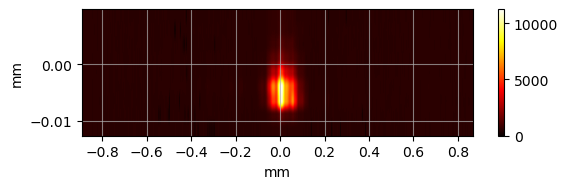

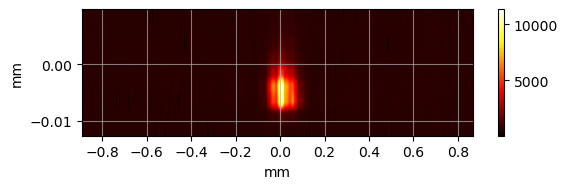

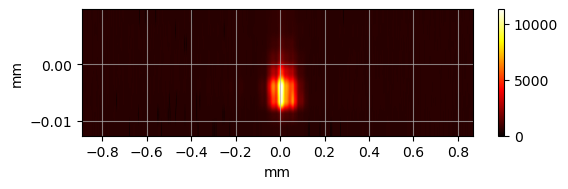

In [778]:
with client.locked():
    beamshaper.apply_Ein(input_beam_bs, 0.3)

    dmd.apply_image_hold(img_on)
    time.sleep(0.5)
    linecam.show_image()

    dmd.apply_image_hold(img_bs_1)
    time.sleep(0.5)
    linecam.show_image()

    dmd.apply_image_hold(img_bs_2)
    time.sleep(0.5)
    linecam.show_image()

# Loading ML model and devices

In [577]:
from tdwg.datasets.vowels_dataset import create_vowels_datasets
# crazy_reload("tdwg.datasets.vowels_dataset", globals())

In [578]:
"""Create datasets"""
train_dataset, val_dataset, test_dataset = create_vowels_datasets(
    vowel_selection = ['ae', 'ah', 'aw', 'er', 'ih', 'iy', 'uw'])

"""Create input/output modes"""
Nin = train_dataset.dataset.data.shape[-1]
Nout = len(train_dataset.dataset.classes)

In [579]:
w0_in = 9*u.um
xmode_in_lim = 200*u.um
xmode_out_lim = 200*u.um

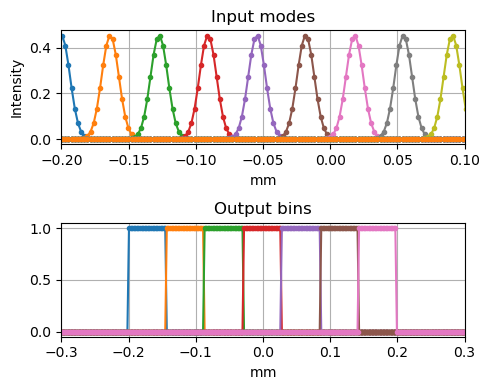

In [580]:
crazy_reload("tdwg.lib.tdwg_plutils", globals())

tdwg_layer = TDwgLayer(tdwg_model, Nin, Nout, w0_in, xmode_in_lim, xmode_out_lim)

plt.figure(figsize = (5,4))

plt.subplot(2,1,1)
for i, input_mode in enumerate(tdwg_layer.input_modes):
    plt.plot(wg.x_axis, torch.abs(input_mode.cpu()), '.-')#**2)
plt.ylabel('Intensity')
plt.title('Input modes')
plt.xlim(-0.2, 0.1)
plt.grid()

plt.subplot(2,1,2)
for output_mode in tdwg_layer.output_modes:
    plt.plot(wg.x_axis, torch.abs(output_mode.cpu())**2, '.-')
plt.xlim(-0.3, 0.3)
plt.title('Output bins')
plt.grid()

plt.tight_layout()

# Training to figure out the hyperparameters

In [623]:
# Parameters of the model!
pname = "vowels_v2"
lr = 1e-1
gamma = 0.99
batch_size = 94

lag_amp = 10
factor = 20

max_epochs = 300
create_checkpoint_every_n_train_steps = 800 #this is for the checkpointing!
log_every_n_steps = 5

In [624]:
from tdwg.lib.custom_plmodels import *
from tdwg.lib.pl_utils import *

crazy_reload("tdwg.lib.custom_plmodels", globals())
crazy_reload("tdwg.lib.pl_utils", globals())

class PNN(pl.LightningModule):
    """
    This class represents the PNN, which consists of digital parameters, 
    input and output encoding procedures, 2Dwg layers and 
    code for training + validation steps.
    """
    def __init__(self, seed = 'identity', mode="insilico"):
        super().__init__()
        # Define PyTorch model
        self.mult = SingleMult(factor_init=2.0)
        tdwg_model = TDwgModel(tdwg_exp, tdwg_sim, mode=mode)
        self.tdwg_layer = TDwgLayer(tdwg_model, Nin, Nout, w0_in, xmode_in_lim, xmode_out_lim, seed=seed)
        
    def forward(self, x):
        x = self.tdwg_layer(x)
        x = self.mult(x)
        
        logits = F.log_softmax(x, dim=1)

        self.save_dict = dict()
        for (name, module) in self.named_modules():
            if hasattr(module, "save_dict"):
                self.save_dict[name] = module.save_dict
        
        return logits

In [625]:
crazy_reload("tdwg.lib.custom_plmodels", globals())

In [626]:
from tdwg.lib.misc_utils import *

In [627]:
# Call the PNN 
pnn = PNN()

#### Write the lagrangian
from tdwg.lib.pnn_utils import lagrangian

def lag_func(pnn):
    lag = lagrangian(pnn.tdwg_layer.tdwg, lag_amp = lag_amp, factor = factor)
    return lag

# Instantiate the model
model = LagrangePlModel(train_dataset, val_dataset, test_dataset,
                      pnn, lag_func, learning_rate=lr, gamma=gamma, 
                        save_outputs_every_n_epochs=1)

In [628]:
torch.manual_seed(0)
x, y = next(iter(model.train_dataloader()))
model.training_step((x, y), 0)

tensor(1.8993, dtype=torch.float64, grad_fn=<AddBackward0>)

In [629]:
from pytorch_lightning.callbacks import LearningRateMonitor
from tdwg.lib.misc_utils import timestring

mode = 'insilico'
name = f"v7"

check_val_every_n_epoch = 1
logger = get_logger(pname, name)

log_dir = get_log_dir(pname, name)
checkpoint_cb = pl.callbacks.ModelCheckpoint(log_dir, 
                 every_n_train_steps = create_checkpoint_every_n_train_steps, save_top_k=-1)

lr_monitor = LearningRateMonitor(logging_interval='epoch')  # or 'epoch'

trainer = pl.Trainer(
    accelerator="auto",
    devices=1,
    max_epochs=20,
    logger = logger, 
    check_val_every_n_epoch = 1,
    log_every_n_steps = log_every_n_steps, 
    callbacks=[checkpoint_cb, lr_monitor],
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [630]:
trainer.fit(model)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name   | Type               | Params
----------------------------------------------
0 | pnn    | PNN                | 281 K 
1 | metric | MulticlassAccuracy | 0     
----------------------------------------------
73.7 K    Trainable params
207 K     Non-trainable params
281 K     Total params
1.126     Total estimated model params size (MB)


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=20` reached.


In [37]:
# for i in model.pnn.mult2.parameters():
#     print(i)

In [38]:
model.pnn.mult.factor

Parameter containing:
tensor(19.8036, requires_grad=True)

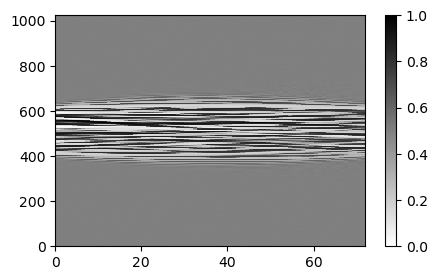

In [39]:
plt.figure(figsize=(5, 3))
plt.pcolormesh(model.pnn.tdwg_layer.tdwg.mod_sim_window.detach().cpu(), vmin=0, vmax=1, cmap="binary")
plt.colorbar()

In [42]:
x, y = next(iter(model.val_dataloader()))
model.to("cuda")
model(x.to("cuda"));

In [43]:
model.pnn

PNN(
  (mult): SingleMult()
  (tdwg_layer): TDwgLayer(
    (tdwg): TDwgModel(
      (tdwg_sim): FineTunedSimulation()
    )
  )
)

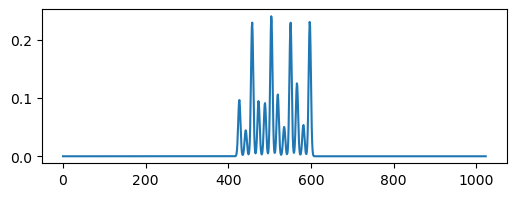

In [44]:
ind = 5
plt.plot(np.real(model.pnn.save_dict["tdwg_layer"]["input_beams"].cpu()[ind]))

In [45]:
from tdwg.lib.plot_utils import *

(-0.3, 0.3)

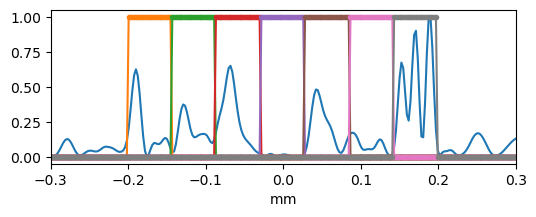

In [46]:
plot_norm(wg.x_axis, np.real(model.pnn.save_dict["tdwg_layer"]["output_intensity"].cpu()[ind]))
for output_mode in tdwg_layer.output_modes:
    plot_norm(wg.x_axis, torch.abs(output_mode.cpu())**2, '.-')
plt.xlim(-0.3, 0.3)

# Generate many mod_sim_windows for digital twin 

This notebook creates a dataset of delta-n patterns for digital twin-training that is hopefully close in distribution to the pattern that PAT will train. This is achieved by creating 200 permutations of the order of input and output modes and training delta-n patterns in-silico. The resulting patterns are saved in "MNIST_dt_data.npz" and loaded in following notebooks.

In [42]:
import matplotlib.pyplot as plt
%matplotlib inline
from tdwg.lib.pl_utils import get_logger
import torch
import pytorch_lightning as pl

In [43]:
AVAIL_GPUS = min(1, torch.cuda.device_count())
device = 'cuda' if AVAIL_GPUS else 'cpu'

In [44]:
from tdwg.lib.io_utils import crazy_reload

In [45]:
from pytorch_lightning.callbacks import LearningRateMonitor

In [46]:
log_every_n_steps = 10
create_checkpoint_every_n_train_steps = 20 #every 10 for vowels
dt_mod_sim_window_max_epochs = 40
seed_list = list(range(100)) # for permutations of inputs/outputs for mod_sim_window samples

In [ ]:
mode = 'insilico'

for seed in seed_list:
    name = f"seed_{seed}"
    logger = get_logger(pname + '_dt_data', name)


    pnn = PNN(seed)
    model = LagrangePlModel(train_dataset, val_dataset, test_dataset,
                          pnn, lag_func, learning_rate=lr, gamma=gamma)
    
    log_dir = get_log_dir(pname + '_dt_data', name)
    filename = '{step}'
    
    checkpoint_cb = pl.callbacks.ModelCheckpoint(log_dir, filename=filename, every_n_train_steps = create_checkpoint_every_n_train_steps, save_top_k=-1)
    lr_monitor = LearningRateMonitor(logging_interval='epoch')  # or 'epoch'
    
    trainer = pl.Trainer(
        accelerator="auto",
        devices=1,
        max_epochs=dt_mod_sim_window_max_epochs,
        logger = logger, 
        # val_check_interval=val_check_interval,
        check_val_every_n_epoch=10,
        log_every_n_steps = log_every_n_steps, 
        callbacks=[checkpoint_cb, lr_monitor],
    )
    
    trainer.fit(model)

In [52]:
from copy import deepcopy

In [53]:
mod_sim_window_list = []
seed_list = list(range(len(seed_list)))
step_list = np.arange(0, dt_mod_sim_window_max_epochs * len(model.train_dataloader()), create_checkpoint_every_n_train_steps)[1:]# + create_checkpoint_every_n_train_steps

for seed in seed_list:
    for step in step_list:
        model = LagrangePlModel.load_from_checkpoint(f"logs/" + pname + f"_dt_data/seed_{seed}/step={step}.ckpt", 
                                              map_location="cpu",
                                              train_dataset = train_dataset,
                                              val_dataset = val_dataset,
                                              test_dataset = test_dataset,
                                              pnn = pnn,
                                              lag_func = lag_func
                                              )
        
        mod_sim_window = deepcopy(model.pnn.tdwg_layer.tdwg.mod_sim_window.detach())
        mod_sim_window_list.append(mod_sim_window)

mod_sim_window_list = torch.stack(mod_sim_window_list)

In [54]:
torch.save(mod_sim_window_list, pname + '_mod_sim_window_list')

# Load data

In [440]:
mod_sim_window_list = torch.load(pname + '_mod_sim_window_list')

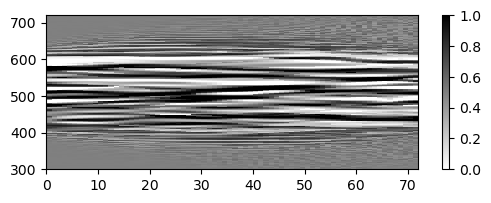

In [441]:
plt.pcolormesh(mod_sim_window_list[100], vmin=0, vmax=1.0, cmap="binary")
plt.ylim(300, 720)
plt.colorbar()

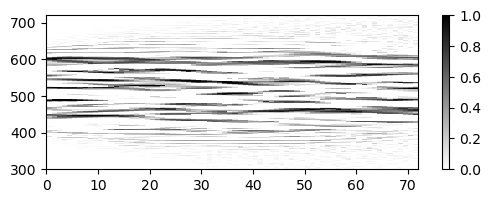

In [442]:
plt.pcolormesh(mod_sim_window_list[1]-mod_sim_window_list[100], vmin=0, vmax=1.0, cmap="binary")
plt.ylim(300, 720)
plt.colorbar()

# Take experimental input-output pairs for digital twin dataset on setup

This notebook takes the previously in-silico-trained delta-n patterns from notebook "3 Generate digital twin mod_sim_window" and sends random inputs through them, to create a set of input-parameter-output-pairs that can be used for training of a digital twin. The recorded input-parameter-output-pairs are saved in "MNIST_dt_data_exp_outputs.npz" and loaded in the following notebooks.

In [443]:
import torch
import matplotlib.pyplot as plt
%matplotlib inline

### Load mod_sim_window_list

### Create random input beams

In [444]:
input_modes = model.pnn.tdwg_layer.input_modes

In [445]:
def make_random_input_beam(seed, N):
    torch.manual_seed(seed)
    
    xrandom = torch.rand(N, input_modes.shape[0], dtype = input_modes.dtype)*2 - 1 - 1j
    input_beam = xrandom @ input_modes

    input_beam /= torch.max(torch.abs(input_beam))
    return input_beam.to(torch.cfloat)

In [446]:
Nx, Nz = converter.mod_sim_window_shape
x_axis_mod_sim_window = np.arange(0, Nx*wg.dx.to('mm').value, wg.dx.to('mm').value)
z_axis_mod_sim_window = np.arange(0, Nz*wg.dz.to('mm').value, wg.dz.to('mm').value)
x_axis_mod_sim_window -= x_axis_mod_sim_window.mean()

In [447]:
# mod_sim_window = mod_sim_window_list[15]
# plt.pcolormesh(z_axis_mod_sim_window, x_axis_mod_sim_window, mod_sim_window)
# plt.colorbar()
# plt.ylim(-0.4, 0.4)

In [448]:
Ein = make_random_input_beam(0, N = 20)
y_pred, wg = tdwg_sim.run_sim_from_mod_sim_window(Ein, mod_sim_window_list[0])

In [449]:
xaxis_th = wg.x_axis

In [450]:
y_exp = tdwg_model.forward_physical(Ein, mod_sim_window_list[0])

In [451]:
from tdwg.lib.plot_utils import *

In [452]:
x_axis_mm = wg.x_axis

(-1.0, 1.0)

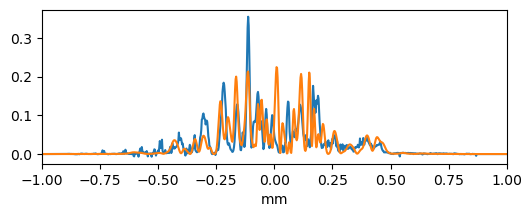

In [464]:
ind = 6
plt.plot(wg.x_axis, y_exp[ind])
plt.plot(wg.x_axis, y_pred[ind])
plt.xlim(-1.0, 1.0)

### With different DMD illumination

In [472]:
n_samples_per_pattern = 64

In [473]:
from tdwg.lib.multiuser_client import Client
from tdwg.lib.sweeps import *

In [474]:
n_DMD_patterns = mod_sim_window_list.shape[0]
Ein_x_th_list = [make_random_input_beam(0, N = n_samples_per_pattern) for i in range(n_DMD_patterns)]

In [475]:
# warm up the system a little but, note that the 
Iout_x_exp_list = torch.stack(sweep_zip(model.pnn.tdwg_layer.tdwg.forward_physical,
                                        Ein_x_th_list[:10], mod_sim_window_list[:10]))

C:\Users\McMahon-lab\McMahon lab Dropbox\peter mcmahon\to232\2D-waveguide\2023-12-24 26Hz vowels\tdwg\lib\line_camera.py:172: UserWarning: There is saturation on camera!
2 pixels are saturated!
  warnings.warn(warn_msg)
  0% 0 of 10 |                                          | Elapsed Time: 0:00:00C:\Users\McMahon-lab\McMahon lab Dropbox\peter mcmahon\to232\2D-waveguide\2023-12-24 26Hz vowels\tdwg\lib\line_camera.py:172: UserWarning: There is saturation on camera!
3 pixels are saturated!
  warnings.warn(warn_msg)
 30% 3 of 10 |############                              | Elapsed Time: 0:00:06C:\Users\McMahon-lab\McMahon lab Dropbox\peter mcmahon\to232\2D-waveguide\2023-12-24 26Hz vowels\tdwg\lib\line_camera.py:172: UserWarning: There is saturation on camera!
1 pixels are saturated!
  warnings.warn(warn_msg)
 60% 6 of 10 |#########################                 | Elapsed Time: 0:00:15C:\Users\McMahon-lab\McMahon lab Dropbox\peter mcmahon\to232\2D-waveguide\2023-12-24 26Hz vowels\tdwg\l

In [ ]:
# warm up the system a little but, note that the 
Iout_x_exp_list = torch.stack(sweep_zip(model.pnn.tdwg_layer.tdwg.forward_physical,
                                        Ein_x_th_list, mod_sim_window_list))

  2% 13 of 500 |#                                       | Elapsed Time: 0:00:38C:\Users\McMahon-lab\McMahon lab Dropbox\peter mcmahon\to232\2D-waveguide\2023-12-24 26Hz vowels\tdwg\lib\line_camera.py:172: UserWarning: There is saturation on camera!
5 pixels are saturated!
  warnings.warn(warn_msg)
  4% 23 of 500 |#                                       | Elapsed Time: 0:01:10C:\Users\McMahon-lab\McMahon lab Dropbox\peter mcmahon\to232\2D-waveguide\2023-12-24 26Hz vowels\tdwg\lib\line_camera.py:172: UserWarning: There is saturation on camera!
6 pixels are saturated!
  warnings.warn(warn_msg)


In [485]:
Ein_x_th_list = [make_random_input_beam(0, N = n_samples_per_pattern) for i in range(n_DMD_patterns)]
Ein_x_th_list = torch.stack(Ein_x_th_list)

In [486]:
np.savez(pname+'_dt_data_exp_outputs.npz',
        Iout_x_exp_list = Iout_x_exp_list,
        Ein_x_th_list = Ein_x_th_list,
        mod_sim_window_list = mod_sim_window_list)

# Train digital twin

This notebook loads the previously recorded "input-parameter-output-pairs" from "MNIST_dt_data_exp_outputs.npz" and trains a digital twin on them. The resulting digital twin is saved in "tdwg_sim.pth" and loaded in the following notebook.

In [487]:
# import torch
from torch.utils.data import Dataset, DataLoader
# import numpy as np
# import pytorch_lightning as pl

# from pnn import PNN, converter
# from pl_utils import LitMNIST, CustomCheckpoint, get_log_dir
# from tdwg.lib.sweeps import sweep_zip
# from tdwg.lib.tdwgnet import FineTunedSimulation
# from tdwg.lib.pl_utils import get_logger

In [488]:
import warnings
warnings.filterwarnings("ignore", ".*does not have many workers.*")

In [489]:
AVAIL_GPUS = min(1, torch.cuda.device_count())
device = 'cuda' if AVAIL_GPUS else 'cpu'

In [490]:
class CustomDataset(Dataset):
    def __init__(self, Ein, Iout, Iout_th, mod_sim_window_list):
        self.Ein = torch.tensor(Ein, dtype=torch.complex64)
        self.Iout = torch.tensor(Iout, dtype=torch.float64)
        self.Iout_th = torch.tensor(Iout_th, dtype=torch.float64)
        self.mod_sim_window_list = torch.tensor(mod_sim_window_list, dtype=torch.float64)

    def __len__(self):
        return len(self.Ein)

    def __getitem__(self, idx):
        return {'input': self.Ein[idx], 
                'output': self.Iout[idx], 
                'output_th': self.Iout_th[idx],
                'mod_sim_window_list': self.mod_sim_window_list[idx]}
        
class LitNumpyArray(pl.LightningModule):
    def __init__(self, Ein, Iout, Iout_th, mod_sim_window_list):
        super(LitNumpyArray, self).__init__()
        self.tdwg_sim = FineTunedSimulation(converter, train_flag=True)
        self.Ein = Ein
        self.Iout = Iout
        self.Iout_th = Iout_th
        self.mod_sim_window_list = mod_sim_window_list

    def setup(self, stage=None):
        if stage == 'fit':
            # Split data into training and validation sets
            total_samples = len(self.Ein)
            train_samples = int(0.75 * total_samples)
            val_samples = total_samples - train_samples

            self.train_dataset = CustomDataset(self.Ein[:train_samples], self.Iout[:train_samples], self.Iout_th[:train_samples], self.mod_sim_window_list[:train_samples])
            self.val_dataset = CustomDataset(self.Ein[train_samples:], self.Iout[train_samples:], self.Iout_th[train_samples:], self.mod_sim_window_list[train_samples:])

    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=batch_size, shuffle=True)

    def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=batch_size)

    def forward(self, x_list, mod_sim_window_list):
        y_pred_list, wg_list = sweep_zip(
            self.tdwg_sim.run_sim_from_mod_sim_window,
            x_list,
            mod_sim_window_list,
            verbose = False)
        return torch.stack(y_pred_list)

    def training_step(self, batch, batch_idx):
        x, y, mod_sim_window_list = batch['input'], batch['output'], batch['mod_sim_window_list']
        y_pred = self.forward(x, mod_sim_window_list)
        loss = torch.nn.functional.mse_loss(y_pred, y)
        # loss = torch.nn.L1Loss()(y_pred, y)
        self.log("train_loss", loss, prog_bar=True, on_epoch=True, on_step=True)
        return {'loss': loss}

    def validation_step(self, batch, batch_idx):
        x, y, mod_sim_window_list = batch['input'], batch['output'], batch['mod_sim_window_list']
        y_pred = self.forward(x, mod_sim_window_list)
        val_loss = torch.nn.functional.mse_loss(y_pred, y)
        self.log("val_loss", val_loss, prog_bar=True, on_epoch=True, on_step=True)
        return {'val_loss': val_loss}
        
    def predict_step(self, x, mod_sim_window_list):
        return self(x, mod_sim_window_list)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=lr_dt)
        # optimizer = torch.optim.Adadelta(self.parameters(), lr=lr)
        # optimizer = torch.optim.SGD(self.parameters(), lr=lr)
        scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.98)
        return {"optimizer": optimizer, "scheduler": scheduler}

In [491]:
# Example usage:
data = np.load(pname+'_dt_data_exp_outputs.npz')
Ein = data['Ein_x_th_list']
Iout = data['Iout_x_exp_list']
mod_sim_window_list = data['mod_sim_window_list']
n_DMD_patterns, n_samples_per_pattern, _ = Ein.shape

In [492]:
def forward_model(Ein_x_sim, mod_sim_window):
    Iout_x_sim, wg = tdwg_sim.run_sim_from_mod_sim_window(Ein_x_sim, mod_sim_window)
    return Iout_x_sim

In [493]:
tdwg_sim = FineTunedSimulation(converter)
Iout_th = torch.stack(sweep_zip(forward_model, torch.from_numpy(Ein), torch.from_numpy(mod_sim_window_list))).detach()

100% 500 of 500 |#######################################| Elapsed Time: 0:00:53


In [494]:
digital_twin = LitNumpyArray(Ein, Iout, Iout_th, mod_sim_window_list)
digital_twin.tdwg_sim.wg.delta_n = torch.zeros(wg.Nz, wg.Nx, device = device)

In [495]:
batch_size = 64
lr_dt = 1e-2
digital_twin.setup(stage = 'fit')
# digital_twin.to('cuda')
batch = next(iter(digital_twin.train_dataloader()))
x, y, mod_sim_window_list = batch['input'], batch['output'], batch['mod_sim_window_list']
y_pred = digital_twin.forward(x, mod_sim_window_list)

C:\Users\McMahon-lab\AppData\Local\Temp\ipykernel_63076\4277453483.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.Iout_th = torch.tensor(Iout_th, dtype=torch.float64)


In [ ]:
exp_name = f'test_test_lr{lr}_v2'
logger = get_logger(pname + '_dt_training', exp_name)
log_dir = get_log_dir(pname + '_dt_data', exp_name)
filename = '{step}'
checkpoint_cb = pl.callbacks.ModelCheckpoint(log_dir, filename=filename, save_top_k=-1)

trainer = pl.Trainer(
    accelerator="auto",
    devices=1,
    max_epochs=25,
    logger=logger,
    log_every_n_steps=1,
    callbacks=[checkpoint_cb]
)
trainer.fit(digital_twin)

In [497]:
torch.save(digital_twin.tdwg_sim.state_dict(), pname+'_tdwg_sim.pth')

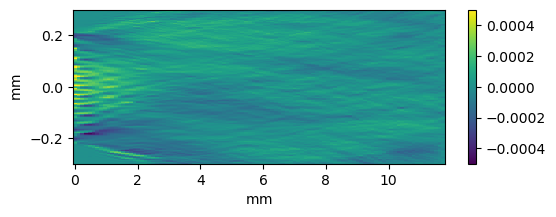

In [712]:
plt.pcolormesh(digital_twin.tdwg_sim.wg.z_axis, digital_twin.tdwg_sim.wg.x_axis, digital_twin.tdwg_sim.background_delta_n.detach().cpu().T, vmin = -5e-4, vmax = 5e-4)
plt.ylim(-0.3, 0.3)
plt.colorbar()

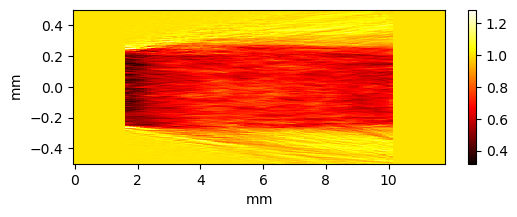

In [713]:
plt.pcolormesh(digital_twin.tdwg_sim.wg.z_axis, digital_twin.tdwg_sim.wg.x_axis, 
               digital_twin.tdwg_sim.modulation_efficiency.detach().cpu().T, cmap="hot")
plt.ylim(-0.5, 0.5)
plt.colorbar()

(-0.3, 0.3)

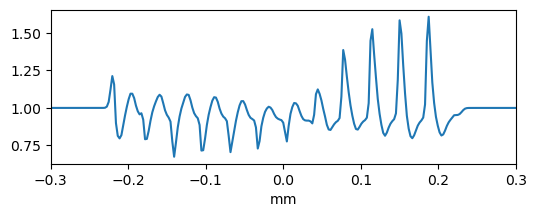

In [714]:
plt.plot(wg.x_axis, digital_twin.tdwg_sim.input_coupling.detach())
plt.xlim(-0.3, 0.3)

(-0.3, 0.3)

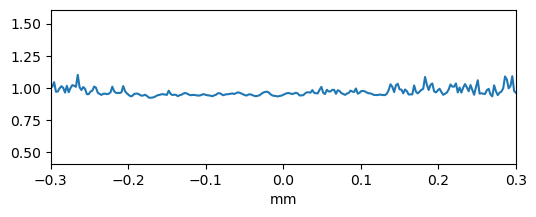

In [715]:
plt.plot(wg.x_axis, digital_twin.tdwg_sim.output_coupling.detach())
plt.xlim(-0.3, 0.3)

In [716]:
input_modes = tdwg_layer.input_modes

### Get visualization of the digital twins!

In [780]:
tdwg_sim = FineTunedSimulation(converter)  # Initialize the model with the same architecture
tdwg_sim.load_state_dict(torch.load(pname+'_tdwg_sim.pth'))

<All keys matched successfully>

In [781]:
Nin = tdwg_layer.input_modes.shape[0]
Ein = make_random_input_beam(seed=0, N = 30)
y_pred, wg = tdwg_sim.run_sim_from_mod_sim_window(Ein, mod_sim_window_list[-1])

In [782]:
xaxis_th = wg.x_axis

In [783]:
y_exp = model.pnn.tdwg_layer.tdwg.forward_physical(Ein, mod_sim_window_list[-1])

In [772]:
from tdwg.lib.plot_utils import *

In [773]:
# Let's revive the 

In [774]:
def plot_grid(x, y_pred, y, ylim=None, xlim=None):
    fig, axs = plt.subplots(3, 3, figsize=(11, 5))
    for (ind, ax) in enumerate(np.ndarray.flatten(axs)):
        ind = ind 
        plt.sca(ax)
        plt.plot(x, y_pred[ind], color="tab:blue", alpha=0.8, label="pred")
        plt.plot(x, y[ind], color="tab:red", alpha=0.7, label="test")
        plt.grid()
        if ylim is not None:
            plt.ylim(ylim)
        if xlim is not None:
            plt.xlim(-xlim, xlim)
        
    plt.legend()
    return fig, axs

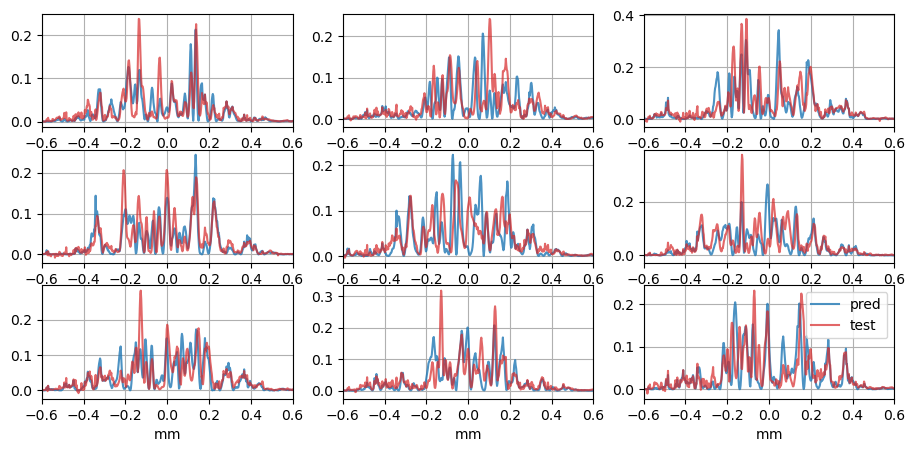

In [775]:
fig, ax = plot_grid(wg.x_axis, y_pred, y_exp, xlim=0.6);


# Train with PAT

This notebook loads the previously trained digital twin from "tdwg_sim.pth" and trains a refractive index pattern using PAT to solve a simplified MNIST task.

## From scratch

In [646]:
from pytorch_lightning.callbacks import LearningRateMonitor

In [647]:
# """Set other ML parameters"""
### FOR MNIST
lr = 1e-1
gamma = 0.99
batch_size = 94

lag_amp = 10
factor = 20

max_epochs = 300
save_outputs_every_n_epochs = 1

mode = 'pat'
name = f"{mode}_v1"
logger = get_logger(pname, name)

In [648]:
pnn = PNN(mode=mode)

In [649]:
from tdwg.lib.pnn_utils import lagrangian

In [650]:
def lag_func(pnn):
    lag = lagrangian(pnn.tdwg_layer.tdwg, lag_amp = lag_amp, factor = factor)
    return lag

In [651]:
model = LagrangePlModel(train_dataset, val_dataset, test_dataset,
                      pnn, lag_func, learning_rate=lr, gamma=gamma, 
                        save_outputs_every_n_epochs=save_outputs_every_n_epochs)

In [652]:
# Load digital twin
model.pnn.tdwg_layer.tdwg.tdwg_sim = FineTunedSimulation(converter)  # Initialize the model with the same architecture
model.pnn.tdwg_layer.tdwg.tdwg_sim.load_state_dict(torch.load(pname+'_tdwg_sim.pth'))
model.pnn.tdwg_layer.tdwg.tdwg_sim.eval()  # Set the model to evaluation mode for inference
# model.pnn.tdwg = TDwgLayer(model.pnn.tdwg_exp, model.pnn.tdwg_sim, mode = mode)

FineTunedSimulation()

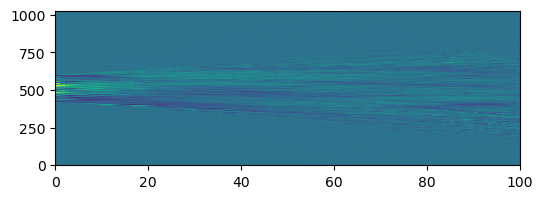

In [653]:
plt.pcolormesh(model.pnn.tdwg_layer.tdwg.tdwg_sim.background_mod.T)

In [654]:
# testing if this will run!
torch.manual_seed(0)
x, y = next(iter(model.train_dataloader()))
model.training_step((x, y), 0)

tensor(2.0830, dtype=torch.float64, grad_fn=<AddBackward0>)

In [655]:
lr_monitor = LearningRateMonitor(logging_interval='epoch')  # or 'epoch'
log_dir = get_log_dir(pname, name)
checkpoint_cb = pl.callbacks.ModelCheckpoint(log_dir, every_n_train_steps = create_checkpoint_every_n_train_steps, save_top_k=-1)

In [656]:
trainer = pl.Trainer(
    accelerator="cpu",
    max_epochs=max_epochs,
    logger = logger, 
    check_val_every_n_epoch = 1,
    log_every_n_steps = log_every_n_steps, 
    callbacks=[checkpoint_cb, lr_monitor],
)

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
C:\Users\McMahon-lab\.conda\envs\tdwg\lib\site-packages\pytorch_lightning\trainer\setup.py:187: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.


In [ ]:
trainer.fit(model)